In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf

import os
from pathlib import Path

## Tomato Predictor - An introduction
The idea of this project is to learn about:

1. Convolutional Neural Networks (CNNs)
    - Convolution and pooling
    - Common arquitectures - LeNet, AlexNet, VGG, ResNet

2. Image Preprocessing
    - Normalization and standarization of pixels
    - Data Augmentation: from the same sample, generate more images
    - Noise reduction and constrast enhancement

3. Evaluation metrics
    - Precission, recall, F1-score
    - Confusion matrix
    - ROC and AUC curve

4. Optimization and regularization
    - Optimization algorithm - SGC, Adam, RMSprop
    - Techniques to avoid overfitting - dropout, batch normalization, early stopping

## Data

### Extracting data from directories

In [2]:
from pathlib import Path

route_train = 'content/ieee-mbl-cls/train'
route_test = 'content/ieee-mbl-cls/val'
 
dynamic_route_train = "{}/{}".format(route_train, "{}")
dynamic_route_test = "{}/{}".format(route_test, "{}")

labels = []
allowed_extension = ".jpg"

def extract_labels(route: str) -> None:
    pathlist = Path(route).iterdir()
    for path in pathlist:
        # because path is object not string
        label = str(path.name)   
        labels.append(label)

def convert_data_to_df(dynamic_route):
    images = {}  # dict with "image_key_name": "label"

    for label in labels:
        path = Path(dynamic_route.format(label))

        for img_path in path.iterdir():
            ext = img_path.suffix.lower()
            if ext != allowed_extension:
                continue
            
            images[img_path.name] = img_path.name[0]

    df = pd.DataFrame({
        "name": list(images.keys()),
        "label": list(images.values()), 
    })
    
    return df
    
extract_labels(route_train)

In [3]:
df = convert_data_to_df(dynamic_route_train)
df = df.sample(frac=1).reset_index(drop=True) # shuffle the dataframe
df.head()

,name,label
0,o (1447).jpg,o
1,d (42).jpg,d
2,r (425).jpg,r
3,o (910).jpg,o
4,r (1371).jpg,r


In [4]:
df_test = convert_data_to_df(dynamic_route_test)
df_test = df_test.sample(frac=1).reset_index(drop=True) # shuffle the dataframe
df_test.head()

,name,label
0,r (2126).jpg,r
1,o (1609).jpg,o
2,o (805).jpg,o
3,u (1368).jpg,u
4,u (773).jpg,u


### From images to pixels

Our images are a 256px x 256px. Then, we have adjust our CNN for this. However, we first have to extract the pixel information of the image in order to be able to process the data in the neural network.

In [5]:
import pandas as pd
from PIL import Image
from numpy import asarray

def add_pixels_image_data(df, route, index, name, target_size=(256, 256)):
    """
    For the row at the specified index, it will append the image's pixel data after processing it.
    The image will be resized and normalized before being added to the DataFrame.
    """
    first = name[0]
    
    if first == 'r':
        first = "Ripe"
    elif first == "o":
        first = "Old"
    elif first == "u":
        first = "Unripe"
    else:
        first = "Damaged"

    path = f"{route}/{first}/{name}"
    image = Image.open(path)
    print(f"Format: {image.format}, pixels: {image.size}, mode: {image.mode}\n")    
    image = image.resize(target_size)

    numpydata = asarray(image)
    numpydata = numpydata.astype('float32')

    if 'image' not in df.columns:
        df['image'] = pd.Series([None] * len(df))

    df.at[index, 'image'] = numpydata / 255 # normalise data [0, 1]

    return df

In [6]:
for index, row in df.iterrows():
    df = add_pixels_image_data(df, route_train, index, row['name'])

Format: JPEG, pixels: (256, 256), mode: RGB

Format: JPEG, pixels: (256, 256), mode: RGB

Format: JPEG, pixels: (256, 256), mode: RGB

Format: JPEG, pixels: (256, 256), mode: RGB

Format: JPEG, pixels: (256, 256), mode: RGB

Format: JPEG, pixels: (256, 256), mode: RGB

Format: JPEG, pixels: (256, 256), mode: RGB

Format: JPEG, pixels: (256, 256), mode: RGB

Format: JPEG, pixels: (256, 256), mode: RGB

Format: JPEG, pixels: (256, 256), mode: RGB

Format: JPEG, pixels: (256, 256), mode: RGB

Format: PNG, pixels: (256, 256), mode: RGBA

Format: JPEG, pixels: (256, 256), mode: RGB

Format: PNG, pixels: (256, 256), mode: RGBA

Format: JPEG, pixels: (256, 256), mode: RGB

Format: JPEG, pixels: (256, 256), mode: RGB

Format: JPEG, pixels: (256, 256), mode: RGB

Format: JPEG, pixels: (256, 256), mode: RGB

Format: JPEG, pixels: (256, 256), mode: RGB

Format: JPEG, pixels: (256, 256), mode: RGB

Format: JPEG, pixels: (256, 256), mode: RGB

Format: JPEG, pixels: (256, 256), mode: RGB

Format: JP

In [7]:
df.head()

,name,label,image
0,o (1447).jpg,o,"[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,..."
1,d (42).jpg,d,"[[[0.6431373, 0.7372549, 0.87058824], [0.64313..."
2,r (425).jpg,r,"[[[0.49411765, 0.1254902, 0.21960784], [0.4941..."
3,o (910).jpg,o,"[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,..."
4,r (1371).jpg,r,"[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,..."


In [8]:
df.shape

(5832, 3)

In [9]:
df.at[0, "image"].shape

(256, 256, 3)

In [10]:
for i, img in enumerate(df['image']):
    if img.shape != ((256, 256, 3)):
        df = df.drop(index=i)

In [11]:
df.shape

(5782, 3)

In [12]:
X_train = np.array(df['image'].tolist())
Y_train = np.array(df["label"].tolist())

print(X_train.shape)
print(Y_train.shape)

(5782, 256, 256, 3)
(5782,)


### For the validation images

In [13]:
for index, row in df_test.iterrows():
    df_test = add_pixels_image_data(df_test, route_test, index, row['name'])

Format: JPEG, pixels: (256, 256), mode: RGB

Format: JPEG, pixels: (256, 256), mode: RGB

Format: JPEG, pixels: (256, 256), mode: RGB

Format: JPEG, pixels: (256, 256), mode: RGB

Format: JPEG, pixels: (256, 256), mode: RGB

Format: JPEG, pixels: (256, 256), mode: RGB

Format: JPEG, pixels: (256, 256), mode: RGB

Format: JPEG, pixels: (256, 256), mode: RGB

Format: JPEG, pixels: (256, 256), mode: RGB

Format: JPEG, pixels: (256, 256), mode: RGB

Format: JPEG, pixels: (256, 256), mode: RGB

Format: JPEG, pixels: (256, 256), mode: RGB

Format: JPEG, pixels: (256, 256), mode: RGB

Format: JPEG, pixels: (256, 256), mode: RGB

Format: JPEG, pixels: (256, 256), mode: RGB

Format: JPEG, pixels: (256, 256), mode: RGB

Format: JPEG, pixels: (256, 256), mode: RGB

Format: JPEG, pixels: (256, 256), mode: RGB

Format: JPEG, pixels: (256, 256), mode: RGB

Format: JPEG, pixels: (256, 256), mode: RGB

Format: JPEG, pixels: (256, 256), mode: RGB

Format: JPEG, pixels: (256, 256), mode: RGB

Format: JP

In [15]:
for i, img in enumerate(df_test['image']):
    if img.shape != ((256, 256, 3)):
        df_test = df_test.drop(index=i)

In [16]:
X_val = np.array(df_test["image"].tolist())
Y_val = np.array(df_test["label"].tolist())

print(X_val.shape)
print(Y_val.shape)

(653, 256, 256, 3)
(653,)


## Basic Neural Network

### How to determine the number of nodes and layers?

Funny enough, I found this in StackOverflow: [Publication](https://stackoverflow.com/questions/35520587/how-to-determine-the-number-of-layers-and-nodes-of-a-neural-network).

---
For the **layers**, just keep adding layers until the test error does not improve anymore.

For the **nodes**, you should have one node per feature (in the input layer), which makes sense. In this case, we only have one feature, but we can convert that list of `196608` pixels $\rightarrow$ `196608` nodes... But this might not be optimal, so better be to not flatten that image.

---
When selecting the nodes, its important to know that:
- CNN: we maintain the original structure of the image (x, y, RGB#)
- Dense: we must flatten the image data `.flatten()`


In [19]:
from tensorflow.keras import models
from tensorflow.keras import layers

In [20]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

In [21]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 60, 60, 64)     │        36,928 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 56,320 (220.00 KB)

 Trainable params: 56,320 (220.00 KB)

 Non-trainable params: 0 (0.00 B)

In [22]:
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(4, activation="softmax"))

In [23]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 60, 60, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 230400)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │    14,745,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,802,244 (56.47 MB)

 Trainable params: 14,802,244 (56.47 MB)

 Non-trainable params: 0 (0.00 B)

In [24]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

Y_train_encoded = label_encoder.fit_transform(Y_train)
Y_val_encoded = label_encoder.transform(Y_val)

In [27]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

history = model.fit(X_train, Y_train_encoded, epochs=10, 
                    validation_data=(X_val, Y_val_encoded))

Epoch 1/10
181/181 ━━━━━━━━━━━━━━━━━━━━ 99s 541ms/step - accuracy: 0.7531 - loss: 0.6280 - val_accuracy: 0.8560 - val_loss: 0.3704
Epoch 2/10
181/181 ━━━━━━━━━━━━━━━━━━━━ 98s 542ms/step - accuracy: 0.8713 - loss: 0.3276 - val_accuracy: 0.8622 - val_loss: 0.3359
Epoch 3/10
181/181 ━━━━━━━━━━━━━━━━━━━━ 101s 556ms/step - accuracy: 0.9014 - loss: 0.2620 - val_accuracy: 0.8714 - val_loss: 0.3016
Epoch 4/10
181/181 ━━━━━━━━━━━━━━━━━━━━ 103s 568ms/step - accuracy: 0.9094 - loss: 0.2345 - val_accuracy: 0.8637 - val_loss: 0.3217
Epoch 5/10
181/181 ━━━━━━━━━━━━━━━━━━━━ 105s 581ms/step - accuracy: 0.9282 - loss: 0.2057 - val_accuracy: 0.9096 - val_loss: 0.2335
Epoch 6/10
181/181 ━━━━━━━━━━━━━━━━━━━━ 98s 539ms/step - accuracy: 0.9417 - loss: 0.1593 - val_accuracy: 0.8652 - val_loss: 0.3821
Epoch 7/10
181/181 ━━━━━━━━━━━━━━━━━━━━ 105s 581ms/step - accuracy: 0.9380 - loss: 0.1648 - val_accuracy: 0.8545 - val_loss: 0.3882
Epoch 8/10
181/181 ━━━━━━━━━━━━━━━━━━━━ 106s 587ms/step - accuracy: 0.9290 - lo

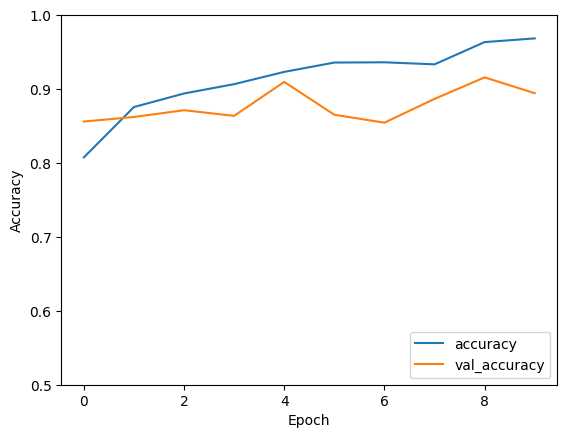

In [29]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

#test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

In [34]:
model.save('tomatoPredictor.keras')

In [35]:
model = tf.keras.models.load_model('tomatoPredictor.keras')

/Users/idb0123/Desktop/tomato-predictor/.venv/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 12 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


The alert is only important if you want to continue with the training. Otherwise, we don't care.